<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/final_model/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import listdir

files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_train/')

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [ ]:
import gc 

import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.layers import GRU, Dense
import tensorflow_addons as tfa
from sklearn.metrics import classification_report

In [ ]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [ ]:
!unzip -o /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip \
 train_labels.csv

Archive:  /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip
  inflating: train_labels.csv        


In [ ]:
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

In [ ]:
train_labels.shape

(458913, 2)

In [ ]:
def append_label(source_df):
  return pd.merge(left=source_df, right=train_labels, how='inner')

In [ ]:
def my_generator():
    for f in files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_train/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      X = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)
      print(f'X shape = {X.shape}')
      yield X, Y.to_numpy()
      




In [ ]:
def my_input_fn(epochs):
    dataset = tf.data.Dataset.from_generator(lambda: my_generator(),
                                             output_types=(tf.float64, tf.int64),
                                            output_shapes=(tf.TensorShape([None, 13, 188]), tf.TensorShape([None, 1])))

    dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset


In [ ]:
f1_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(13, 188)))
model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                48768     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 49,165
Trainable params: 49,165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 5
dataset = my_input_fn(epochs)
model.fit(dataset, epochs=epochs)


Epoch 1/5
X shape = (7508, 13, 188)
      1/Unknown - 11s 11s/step - loss: 0.7077 - accuracy: 0.4201 - f1_score: 0.3268X shape = (41994, 13, 188)
      2/Unknown - 32s 21s/step - loss: 0.6708 - accuracy: 0.6592 - f1_score: 0.3136X shape = (42089, 13, 188)
      3/Unknown - 50s 19s/step - loss: 0.6512 - accuracy: 0.7123 - f1_score: 0.2749X shape = (41911, 13, 188)
      4/Unknown - 71s 20s/step - loss: 0.6342 - accuracy: 0.7328 - f1_score: 0.2382X shape = (42029, 13, 188)
      5/Unknown - 93s 20s/step - loss: 0.6197 - accuracy: 0.7428 - f1_score: 0.2103X shape = (42098, 13, 188)
      6/Unknown - 112s 20s/step - loss: 0.6064 - accuracy: 0.7495 - f1_score: 0.1904X shape = (42038, 13, 188)
      7/Unknown - 130s 20s/step - loss: 0.5949 - accuracy: 0.7539 - f1_score: 0.1750X shape = (42037, 13, 188)
      8/Unknown - 147s 19s/step - loss: 0.5847 - accuracy: 0.7572 - f1_score: 0.1635X shape = (7508, 13, 188)
      9/Unknown - 150s 17s/step - loss: 0.5830 - accuracy: 0.7577 - f1_score: 0.16

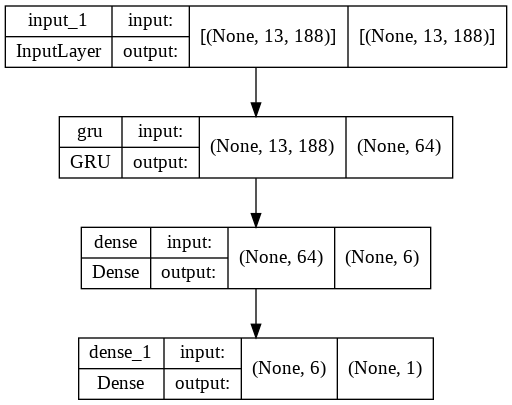

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="/tmp/model.png", show_shapes=True)

In [ ]:
val_files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_val/')

In [ ]:
def my_val_generator():
    for f in val_files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_val/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      X = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)
      print(f'X shape = {X.shape}')
      yield X, Y.to_numpy()

In [ ]:
def my_val_input_fn():
    dataset = tf.data.Dataset.from_generator(lambda: my_val_generator(),
                                             output_types=(tf.float64, tf.int64),
                                            output_shapes=(tf.TensorShape([None, 13, 188]), tf.TensorShape([None, 1])))

    # dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset

In [ ]:
val_dataset = my_val_input_fn()
model.evaluate(val_dataset)

X shape = (42194, 13, 188)
1/1 [==============================] - 16s 16s/step - loss: 0.2745 - accuracy: 0.9067 - f1_score: 0.7980


[0.27451565861701965, 0.9067165851593018, array([0.79800886], dtype=float32)]

In [ ]:
y_pred = (model.predict(val_dataset) > 0.5).astype("int32")

X shape = (42194, 13, 188)


In [ ]:
for x, y in val_dataset:
  y_test=y

X shape = (42194, 13, 188)


In [ ]:
y_test.shape

TensorShape([42194, 1])

In [ ]:
y_pred.shape

(42194, 1)

In [ ]:
f1_score(y_test, y_pred)

0.7980088268500461

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9399    0.9388    0.9394     32470
           1     0.7965    0.7996    0.7980      9724

    accuracy                         0.9067     42194
   macro avg     0.8682    0.8692    0.8687     42194
weighted avg     0.9068    0.9067    0.9068     42194

